### Стартер 5
# 🏬 DWthon 5.0 - прогнозирование еженедельных продаж на год вперед 🏬

![](./images/ecommerce.png)

Последний стартер перед Тобой, но помни, что это не последний шаг, который можешь сделать. Это всего лишь руководство для тех, кто нуждается в поддержке. Цель соревнований - попробовать все, что здесь есть ;), но общая цель - развитие :) Поэтому есть стартеры, которые нужно делать только с пониманием и иметь какой-то минимальный опыт, позволяющий разгоняться.


Что происходит в этом стартере?

1. Я сделал то, чего никогда не делаю 😱 Я удалил строки 😱 Не считай это чем-то достойным повторения в каждой ситуации, наоборот, лучше этого не делать, но стоит иметь в виду, что бывают ситуации, когда можно это сделать, если улучшится результат и этих строк мало.

2. Я логарифмирую целевую переменную. Смотри, что получилось :)

## 📥 Импортируем нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score

import xgboost as xgb
import catboost as ctb

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)
import seaborn as sns

## 🗃️  Загружаем данные


In [2]:
df_sales_train = pd.read_hdf("./input/sales_train.h5")
df_sales_test = pd.read_hdf("./input/sales_test.h5")

df_sales_train["date"] = pd.to_datetime(df_sales_train["date"])

df_sales_train = df_sales_train.sort_values(by=["store", "dept", "date"])
df_sales_test["date"] = pd.to_datetime(df_sales_test["date"])

df_sales_train.head(10)

,id,weekly_sales,store,dept,date,is_holiday
79017,79017,20094.189453,1,1,2010-01-10,False
81351,81351,57258.429688,1,1,2010-02-04,False
256391,256391,16333.139648,1,1,2010-02-07,False
115305,115305,41595.550781,1,1,2010-02-19,False
351187,351187,19403.539062,1,1,2010-02-26,False
286688,286688,16241.780273,1,1,2010-03-09,False
37947,37947,22517.560547,1,1,2010-03-12,False
72620,72620,22136.640625,1,1,2010-03-19,False
384329,384329,26229.210938,1,1,2010-03-26,False
294658,294658,17558.089844,1,1,2010-04-06,False


Воспользуемся предыдущим кодом.

In [3]:
def feature_engineering(df):
    df["dayofweek"] = df["date"].dt.dayofweek
    df["dayofyear"] = df["date"].dt.dayofyear
    df["week"] = df["date"].dt.week
    df["month"] = df["date"].dt.month

    
    return df

df_sales_train = feature_engineering(df_sales_train)
df_sales_test = feature_engineering(df_sales_test)


df_store = df_sales_train[ ["store", "dept", "weekly_sales"] ].groupby(["store", "dept"]).agg(["mean", "std", "median", "size"])["weekly_sales"].reset_index()
df_store.head()


df_sales_train_ext = pd.merge(df_sales_train, df_store, on=["store", "dept"], how="left").fillna(-1)
df_sales_test_ext = pd.merge(df_sales_test, df_store, on=["store", "dept"], how="left").fillna(-1)
df_sales_train_ext.head()

/tmp/ipykernel_61/3090744413.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["week"] = df["date"].dt.week


,id,weekly_sales,store,dept,date,is_holiday,dayofweek,dayofyear,week,month,mean,std,median,size
0,79017,20094.189453,1,1,2010-01-10,False,6,10,1,1,22494.710938,9784.865055,18820.289062,97
1,81351,57258.429688,1,1,2010-02-04,False,3,35,5,2,22494.710938,9784.865055,18820.289062,97
2,256391,16333.139648,1,1,2010-02-07,False,6,38,5,2,22494.710938,9784.865055,18820.289062,97
3,115305,41595.550781,1,1,2010-02-19,False,4,50,7,2,22494.710938,9784.865055,18820.289062,97
4,351187,19403.539062,1,1,2010-02-26,False,4,57,8,2,22494.710938,9784.865055,18820.289062,97


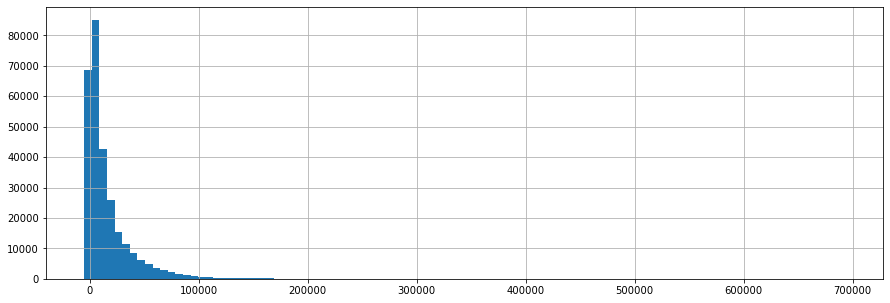

In [4]:
df_sales_train["weekly_sales"].hist(bins=100);

## ⚙️Подготовка `X`, `y`

У нас уже есть признаки, теперь мы можем подготовить нашу матрицу.

In [5]:
feats = ["store", "dept", "is_holiday", "week", "mean", "std", "median", "size"]

X_train = df_sales_train_ext[ feats ].values
X_test = df_sales_test_ext[ feats ].values



y_train = df_sales_train_ext["weekly_sales"].values
X_train = X_train[ y_train > 0 ]
y_train = y_train[ y_train > 0 ]


y_train_log = np.log(y_train)

Обрати внимание, что `y_train` также имеет отрицательные значения. Логарифм с этим не справляется, поэтому мы удалили строки, где продажи отрицательные (кстати, интересно, почему продажи были отрицательными?). К счастью, таких строк было немного.

## Обучаем модель

Обучим модель прогнозированию.

⌛️⌛️⌛️ Само обучение займет «немного» времени, просто подожди минуту или дольше. Модель учится 🦾.

In [6]:
model = xgb.XGBRegressor(max_depth=10, n_estimators=500, learning_rate=0.1, random_state=0)
model.fit(X_train, y_train_log)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## 🌎 Submit

In [7]:
!mkdir -p ./output

In [8]:
df_sales_test["weekly_sales"] = np.exp(model.predict(X_test))

df_sales_test[ ["id", "weekly_sales"] ].to_csv("./output/simple_xgb_log.csv", index=False)

## Что дальше ;)

Стоит больше заниматься **feature engineering**. Больше экспериментов.

Экспериментируй, но избегай «черных дыр». Одним словом, применяй на практике правило 80 на 20.

In [9]:
## YOUR CODE HERE

## 🤝🗣️ Совместное обсуждение и обмен опытом 💬
Соревнование соревнованием, но во всем этом есть нечто большее, чем победа...

👉 *сотрудничество, общение, творческое и критическое мышление* - это ценности и навыки, о которых стоит заботиться

Прежде всего, речь идет о том, чтобы как можно больше учиться и поддерживать друг друга. Помни о здоровой конкуренции и взаимной помощи
🤝 

Для проведения конкурса в Kaggle мы создали отдельные каналы:
- [#dwthon_general](https://dataworkshop-ru.slack.com/archives/C02NRMNLE2D) - **общий канал**
- [#dwthon_ideas](https://dataworkshop-ru.slack.com/archives/C02N6CBK1CN) - **канал, где можно делиться мыслями и идеями**
- [#dwthon_questions](https://dataworkshop-ru.slack.com/archives/C02N6C69G3Y) - **канал, где можно задавать вопросы**


##  Некоторые факты о `DWClub`:
- Участники `DW Club` имеют доступ к материалам 24/7
- Этот интенсив - уже очередной материал для `DW Club`, и с каждым месяцем их количество будет только увеличиваться.
- Участникам `DW Club` предоставляются более выгодные условия покупки платных курсов и т.д.

Узнай больше [нажав на ссылку](https://dataworkshop.ru/data-science/dw-club).